In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

from datetime import date

import yfinance as yf

import pickle

In [79]:
def PlotData(data, graph_title, graph_name):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data)
    plt.title(graph_title)
    # plt.show()

    plt.savefig(f'./stockpred/static/{graph_name}.png', format='png')

In [5]:
def MinMaxData(data, col_name):
    x = data.describe()
    x = x[col_name]
    # minVal = np.int32(x.loc['min'])
    minVal = x.loc['min']
    # minVal = round(minVal, 4)
    # maxVal = np.int32(x.loc['max'])
    # maxVal = round(maxVal, 4)
    maxVal = x.loc['max']

    return minVal, maxVal

In [48]:
def DataImport(stock_name):
    # t_day = date.today()
    # data = yf.download(stock_name, start=f"{t_day.year - 5}-01-01", end=f"{t_day.year}-{t_day.month-1}-01")
    data = yf.download(stock_name)
    close_data = data['Close']
    PlotData(close_data, stock_name, f"{stock_name} Data")
    open_min, open_max = MinMaxData(data, 'Open')
    high_min, high_max = MinMaxData(data, 'High')
    low_min, low_max = MinMaxData(data, 'Low')
    vol_min, vol_max = MinMaxData(data, 'Volume')
    
    d = {"open_min": open_min, "open_max": open_max, "high_min": high_min, "high_max": high_max, 
    "low_min": low_min, "low_max": low_max, "vol_min": vol_min, "vol_max": vol_max}

    return data, d


[*********************100%%**********************]  1 of 1 completed


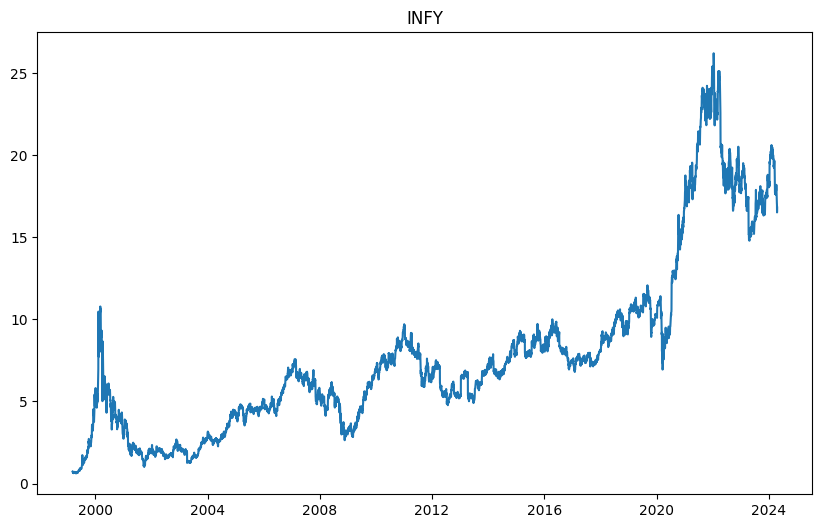

In [49]:
data, d = DataImport("INFY")

In [66]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-03-11,0.5840,0.7812,0.5840,0.7324,0.483835,172512000
1999-03-12,0.7344,0.7617,0.6719,0.7285,0.481255,39897600
1999-03-15,0.7305,0.7305,0.6582,0.6621,0.437387,12672000
1999-03-16,0.6680,0.6914,0.6562,0.6562,0.433516,9984000
1999-03-17,0.6562,0.6992,0.6523,0.6602,0.436097,15449600
...,...,...,...,...,...,...
2024-04-15,17.6900,17.7100,17.2600,17.2700,17.270000,11374300
2024-04-16,16.9800,17.1900,16.9800,17.0500,17.049999,13033300
2024-04-17,17.1400,17.1800,16.8700,16.9500,16.950001,17034100


In [51]:
def modelBuilding(data):
    columns_to_4decimal = ['Open', 'High', 'Low', 'Close']

    data[columns_to_4decimal] = np.round(data[columns_to_4decimal],4)
    # print(data)
    X = data[['Open', 'Low', 'High', 'Volume']]
    y = data['Close']

    #split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    #creates the svr model
    svr_model = SVR(kernel = 'rbf', C=100, epsilon=0.1)


    #train the model
    svr_model.fit(X_train_scaled, y_train)

    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)


    #defines the parameter for grid search 
    param_grid = {
        'kernel': ['linear', 'rbf'],
        'C': [1, 10, 50, 100],
        'epsilon': [0.01, .1, 0.2, 0.5]
    }
    svr = SVR()

    grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    normal_pred = grid_search.fit(X_train_normalized, y_train)

    best_params = grid_search.best_params_


    #trains the model with the best parameter 
    best_svr_model = SVR(**best_params)
    best_svr_model.fit(X_train_normalized, y_train)

    return best_svr_model, scaler

In [52]:
model, scaler = modelBuilding(data)

In [53]:
def Next30_days(data, d):
    new_data = pd.DataFrame()
    new_data['Date'] = pd.to_datetime(data.index)
    new_data = new_data.sort_values(by='Date')

    # Extract the last date in the data
    last_date = new_data['Date'].max()

    # Generate dates for the next 30 days
    next_30_days_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

    # Create a DataFrame for the next 30 days data
    next_30_days_data = pd.DataFrame({'Date': next_30_days_dates})
    
    # next_30_days_data['Volume'] = np.random.randint(100000, 500000, size=len(next_30_days_data))
    next_30_days_data['Open'] = np.random.randint(d['open_min'], d['open_max'], size=len(next_30_days_data))
    next_30_days_data['Low'] = np.random.randint(d['low_min'], d['low_max'], size=len(next_30_days_data))
    next_30_days_data['High'] = np.random.randint(d['high_min'], d['high_max'], size=len(next_30_days_data))
    next_30_days_data['Volume'] = np.random.randint(d['vol_min'], d['vol_max'], size=len(next_30_days_data))

    next_30_days_data.set_index('Date', inplace=True)
    # Print or use the prepared next 30 days data
    # print(next_30_days_data)

    return next_30_days_data

In [54]:
def predictData(data, d):
    next_30_days_data = Next30_days(data, d)

    next_30_days_scaled = scaler.transform(next_30_days_data)

    # Make predictions for the next 30 days
    predictions_next_30_days = model.predict(next_30_days_scaled)

    return predictions_next_30_days, next_30_days_data

In [55]:
pred, next_data = predictData(data, d)

In [56]:
def CombineData(data, pred, next_data):
    original_close_data = pd.DataFrame()
    original_close_data['Close'] = data['Close']
    df = pd.DataFrame(pred, index=next_data.index)
    df.columns = ['Close']
    # original_close_data
    # df
    predicted_30_days_data_combined = pd.concat([original_close_data, df])
    
    return predicted_30_days_data_combined

In [57]:
data_final = CombineData(data, pred, next_data)

In [58]:
x = data_final['Close']
x = x[::-100]
x

Date
2024-05-19    17.212561
2024-01-09    18.250000
2023-08-16    17.130000
2023-03-23    16.940000
2022-10-27    18.510000
                ...    
2000-12-15     3.859400
2000-07-26     3.800800
2000-03-03    10.265600
1999-10-11     2.671900
1999-05-19     0.671900
Name: Close, Length: 64, dtype: float64

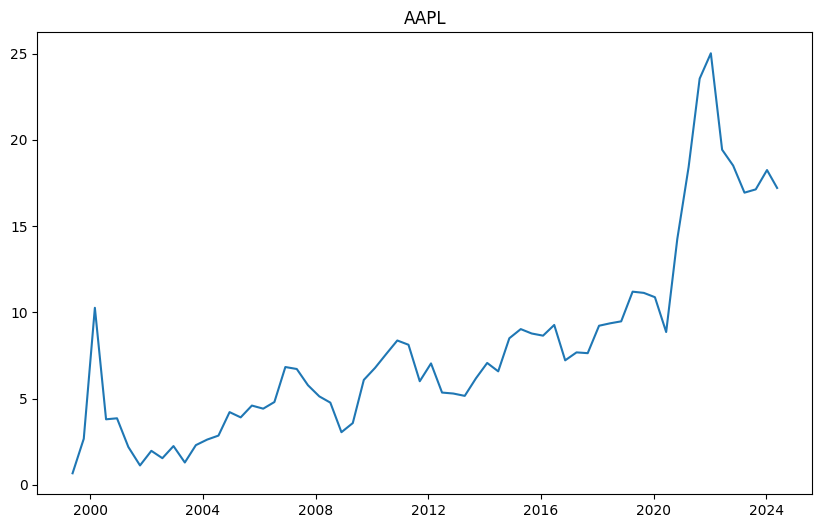

In [59]:
PlotData(x, "AAPL", "Data Prediction")

In [74]:
def OneYear_data(data):
    data = data['Close']
    one_year_data = data.tail(365)
    PlotData(one_year_data, "Yearly Stock Data", "x")

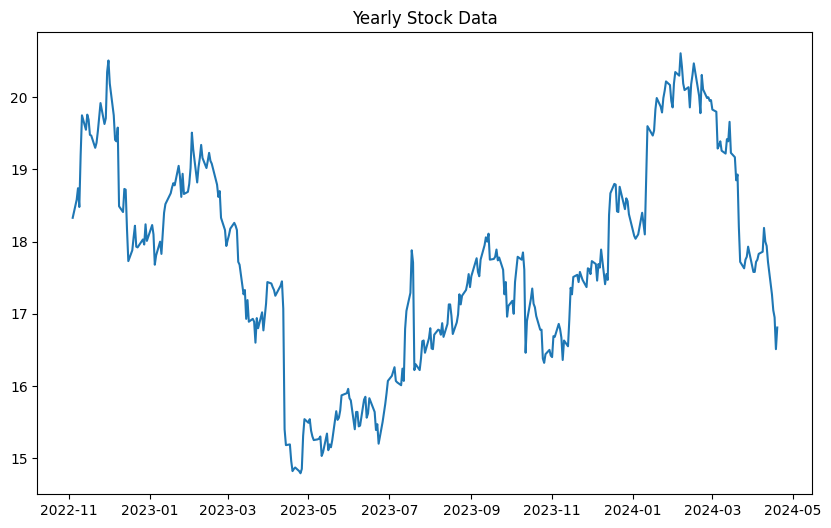

In [75]:
OneYear_data(data)

In [72]:
def LastMonth_data(data):
    data = data['Close']
    last_moth_data = data.tail(30)
    PlotData(last_moth_data, "Monthly Stock Data", "x")

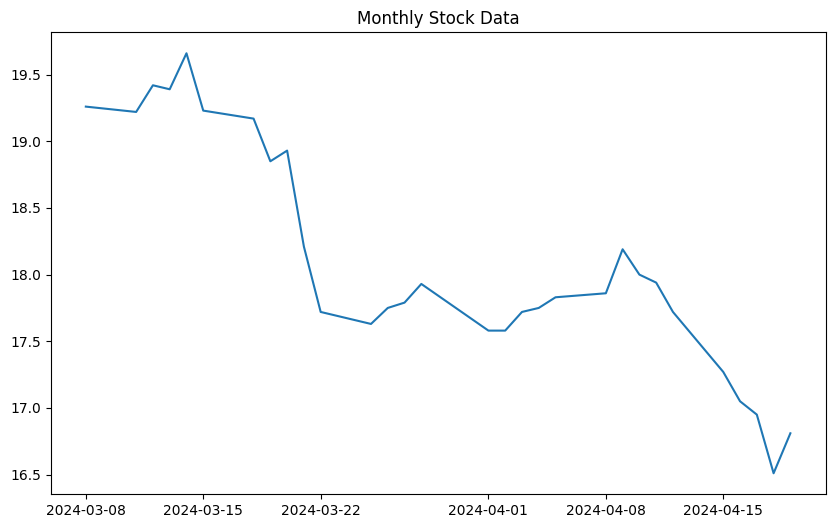

In [73]:
LastMonth_data(data)

In [77]:
def LastWeek_data(data):
    data = data['Close']
    last_week_data = data.tail(7)
    PlotData(last_week_data, "Weekly Stock Data", "x")

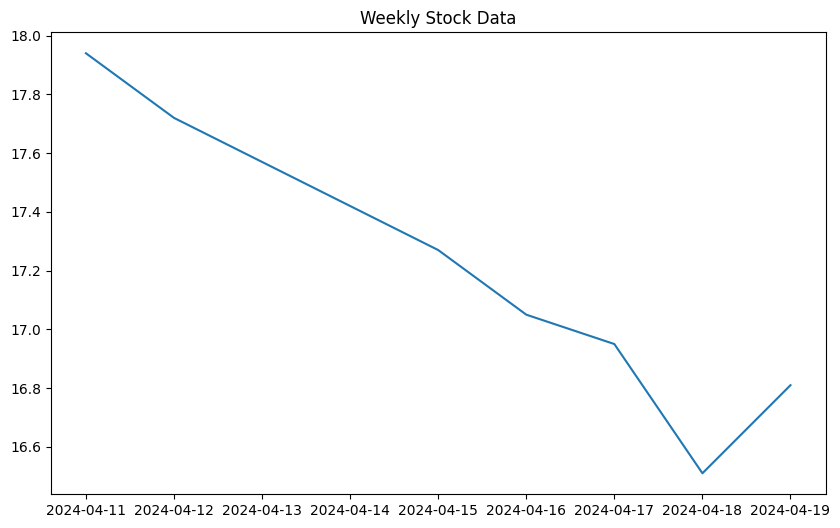

In [78]:
LastWeek_data(data)

In [80]:
data = {
    "plot": PlotData,
    "minmax": MinMaxData,
    "dataImport": DataImport,
    "model": modelBuilding,
    "next30": Next30_days,
    "predictData": predictData,
    "combine": CombineData,
    "year": OneYear_data,
    "month": LastMonth_data,
    "week": LastWeek_data,
}

In [81]:
with open('svm_final.pkl', 'wb') as file:
    pickle.dump(data, file)